In [1]:
import numpy as np
import gmsh
from scipy.linalg import eigh 
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm_notebook

In [2]:
plt.rc('figure', figsize=(15,8))
plt.rc('axes', labelsize=24)
plt.rc('xtick', labelsize=20)
plt.rc('ytick', labelsize=20)

In [3]:
'''Aca establesco las condiciones de mi problema, en este caso son las de la guia'''

Largo = 1
Area = 10e-4 
Inercia = 10e-8
densidad = 7850
Modulo_E = 210e9

Numero_de_elementos = 3

In [4]:
'''Se define una funcion a la cual le ingresa un dado numero de elementos y me devuelve un vector con las frecuencias de los modos normales
 y una matriz con los modos normales normalizados'''

def frec_de_N (Numero_de_elementos):
    
    Largo_elemento = Largo/Numero_de_elementos # Segun el numero de elementos sera el largo de cada uno de ellos

    n = (Numero_de_elementos*2) + 2  #El numero de nodos es Numero_de_elementos+1 aca multiplico ese valos por 2 para armar las matrices de rigidez y de masa
    
    Matriz_rigidez = np.zeros((n,n))  #aca es muy importante aclarar que cada nodo tiene 2 grados de libertad 1 para el angulo y 
    Matriz_masa = np.zeros((n,n))     #otro para el desplazamiento para este ejercicio solo interesa los desplazamientos
    

    for i in range(Numero_de_elementos):   #voy a ir barriendo cada elemento 

        p = i ; j = i+1                   #le otorga a cada elemento los 'nombres' de sus nodos, basicamente los numera

        #Aca se define la matriz de masa concentrada
        '''
         Matriz_m = ((densidad*Largo_elemento*Area)/24) * np.array([
                                                                   [12,0,0,0],
                                                                   [0,Largo_elemento**2,0,0],
                                                                   [0,0,12,0],
                                                                   [0,0,0,Largo_elemento**2]
                                                                   ])
        '''
        #Aca se define la matriz de masa consistente

        Matriz_m = ((densidad*Largo_elemento*Area)/420) * np.array([
                  [156,22*Largo_elemento,54,-13*Largo_elemento],
                  [22*Largo_elemento,4*Largo_elemento**2,13*Largo_elemento,-3*Largo_elemento**2],
                  [54,13*Largo_elemento,156,-22*Largo_elemento],
                  [-13*Largo_elemento,-3*Largo_elemento**2,-22*Largo_elemento,4*Largo_elemento**2]
                  ])

        #Aca se define la matriz de rigidez
        
        Matriz_local = ((Modulo_E*Inercia)/(Largo_elemento**3)) * np.array([
                    [12,  6*Largo_elemento,  -12,   6*Largo_elemento],
                    [6*Largo_elemento,   4*Largo_elemento**2,   -6*Largo_elemento,   2*Largo_elemento**2],
                    [-12,    -6*Largo_elemento,   12,   -6*Largo_elemento],
                    [6*Largo_elemento,  2*Largo_elemento**2,   -6*Largo_elemento,   4*Largo_elemento**2]
                   ])


        # En estas lineas lo que hago es colocar cada uno de los valores de las matrices K y M Locales en sus respectivas posiciones en las K y M globales
        
        A_G = np.array([p*2,p*2+1],dtype = int)
        B_G = np.array([j*2,j*2+1],dtype = int) 
        A_L = np.array([0,1],dtype = int)
        B_L = np.array([2,3],dtype = int)


        Matriz_rigidez[np.ix_(A_G,A_G)] +=  Matriz_local [np.ix_(A_L,A_L)]
        Matriz_rigidez[np.ix_(B_G,B_G)] +=  Matriz_local [np.ix_(B_L,B_L)]
        Matriz_rigidez[np.ix_(A_G,B_G)] +=  Matriz_local [np.ix_(A_L,B_L)]
        Matriz_rigidez[np.ix_(B_G,A_G)] +=  Matriz_local [np.ix_(B_L,A_L)]

        Matriz_masa[np.ix_(A_G,A_G)] +=  Matriz_m [np.ix_(A_L,A_L)]
        Matriz_masa[np.ix_(B_G,B_G)] +=  Matriz_m [np.ix_(B_L,B_L)]
        Matriz_masa[np.ix_(A_G,B_G)] +=  Matriz_m [np.ix_(A_L,B_L)]
        Matriz_masa[np.ix_(B_G,A_G)] +=  Matriz_m [np.ix_(B_L,A_L)]
    
    #Una vez salido del for ya tengo mis K y M globales por lo que solo nos queda la resolucion usando la biblioteca spicy
    
    R = np.arange(2,n)     #Debo resolver todos aquellos grados de libertad en los cuales no tengo anclaje, esto seria del segundo grado de libertad en delante 
    Matriz_rigidez_reducida = Matriz_rigidez[np.ix_(R,R)]
    Matriz_masa_reducida = Matriz_masa[np.ix_(R,R)]
    w, vl = eigh(Matriz_rigidez_reducida, Matriz_masa_reducida)               #encuentro las frecuencias y los modos normales
    vl_normalizado = vl[::2]/vl[::2].max()                                    #aca normalizo los modos normales
    return (vl_normalizado, w)

In [5]:
#voy a guardar los 3 primeros modos:

vlns = []                        #Se genera una lista donde se guardaran los modos normales
modemax  = 3                     #la cantidad de modos normales que voy a recoger, para comparaciones y facilitar la visual solo tomare 3
minelem = 1                      #la cantidad de elementos minimos que voy a barrer

ws = np.nan*np.ones([Numero_de_elementos-minelem+1, modemax])


In [6]:
progress = tqdm_notebook(range(minelem,Numero_de_elementos+1))   #genera un barrido
for N in progress:
    vln, w = frec_de_N(N)
    imax = min(modemax, len(w))
    vlns.append(vln[:,:imax])                             #guarda solo los desplazamientos y no los angulos
    ws[N-minelem, :imax] = np.sqrt(w[:imax])/(2*np.pi)

  0%|          | 0/3 [00:00<?, ?it/s]

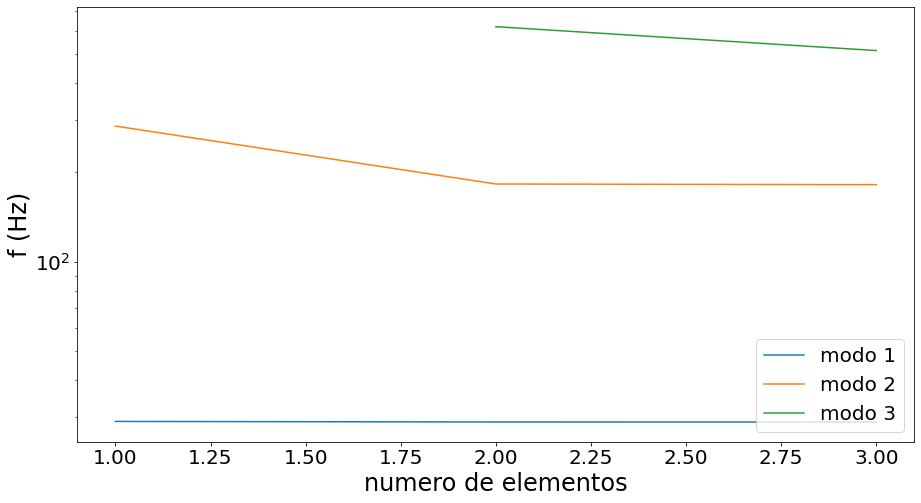

In [8]:
for i in range(modemax): #grafico solo las frecuencias de los 3 primeros modos
    plt.plot(
        np.linspace(minelem, Numero_de_elementos, Numero_de_elementos-minelem+1),
        ws[:,i],
        label='modo %d' % (i+1))
plt.legend(loc = 'lower right',fontsize=20) 
ax = plt.gca()
ax.set_yscale('log')
ax.set_ylabel('f (Hz)')
ax.set_xlabel('numero de elementos')
#plt.savefig("Frecuencias2.png")
plt.show()

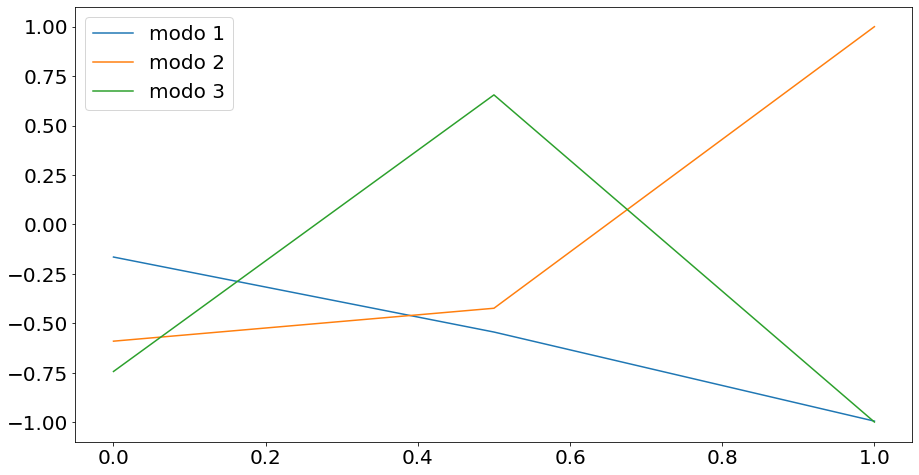

In [9]:
for i in range(modemax): #grafico solo los 3 primeros modos
    distancias = np.linspace(0, Largo, len(vlns[-1][:]))
    plt.plot(distancias, vlns[-1][:,i] , label='modo %d' % (i+1) )  #vlns[-1][:,i] permite graficar solo los desplazamientos del ultimo modo guardado
plt.legend(fontsize=20)      
#plt.savefig("Plot3.png")
plt.show()